# Analysis Using Mean Lights File

This notebook is an example analysis using the [World Bank SEZ dataset](https://data.sandiegodata.org/dataset/worldbank-org-sez/), and the Data Library's processed Mean Nighttime Lights dataset, [SEZ Lights, Rings and Buffers](https://data.sandiegodata.org/dataset/sandiegodata-org-sez-lights/), which provides the sums of pixel values in analysis regions around the SEZ, eliminating the requirements for installing geographic packages. 

The [SEZ Lights, Rings and Buffers](https://data.sandiegodata.org/dataset/sandiegodata-org-sez-lights/) provides sums of the pixel values in the [nighttime lights data](https://data.sandiegodata.org/dataset/figshare-com-harmonized-ntl/) in regions around the SEZs from the [World Bank's SEZ dataset](https://data.sandiegodata.org/dataset/worldbank-org-sez/). The
buffers are a circle for a specified radius around each SEZ, and the rings have
a minimum radius of the specific radius, and a maximum radius of (1+sqrt(2))
times larger, so the area of the ring for a radius is equal to the area of the
buffer circle.

Here is an example of the buffer and ring for an SEZ in South Korea:

<img src="http://library.metatab.org/sandiegodata.org-sez_lights-1.1.2/doc/ring_raster.png" width=720>

This file can be joined to the SEZ data on the ``unique_id`` column. For each
SEZ and year of the NTL data, this file includes the sum of the pixel values
from the NTL rasters for both the ring and the buffer, and the radius specified
in the ``radius`` column. The ``*_count`` column is the number of non-null
pixels in each region.



## About this Analysis

In this notebook we will fit an exponential line to the sum of the pixels in the ring and buffer for each SEZ, for the periods before and after the SEZ was established. Then, we can compare the growth rates before and after the establishment to assess the impact of the SEZ. 

For each ring and buffer, the exponential fit will give us a growth rate, $\beta$. The fitting function is ordinary least squares, so the data series we will fit to has to be log transformed first.  For $X_n$ is the pixel sum for each year in a region, $\alpha$ is our initial value, and $\epsilon$ is an error series:

$$ \begin{gather}
\ln X_n  = \alpha + \beta n + \epsilon  \tag{1} \\
\beta = \ln(1+r)
\end{gather}$$

Now we should be able to regress on equation(1) to get $\beta = \ln(1+r) $, so $r=e^{\beta}-1$


In [1]:
import pandas as pd
from random import choice, shuffle 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 

%matplotlib inline

%run ./lib.py

## Opening Files with Vanilla Pandas

In [2]:
# Main SEZ file
sez_df =  pd.read_csv('http://library.metatab.org/worldbank.org-sez-1.1.1/data/sez.csv')

# The operational date col is a string, so make an int year column. 
sez_df['op_year'] = pd.to_numeric(sez_df.operational_date, errors='coerce')

# Nighttime Lights summaries
mean_lights_df =  pd.read_csv('http://library.metatab.org/sandiegodata.org-sez_lights-1.1.1/data/mean_lights.csv')


dfml = sez_df.merge(mean_lights_df)
df5 = dfml[dfml.radius == 5000]
df10 = dfml[dfml.radius == 10_000]

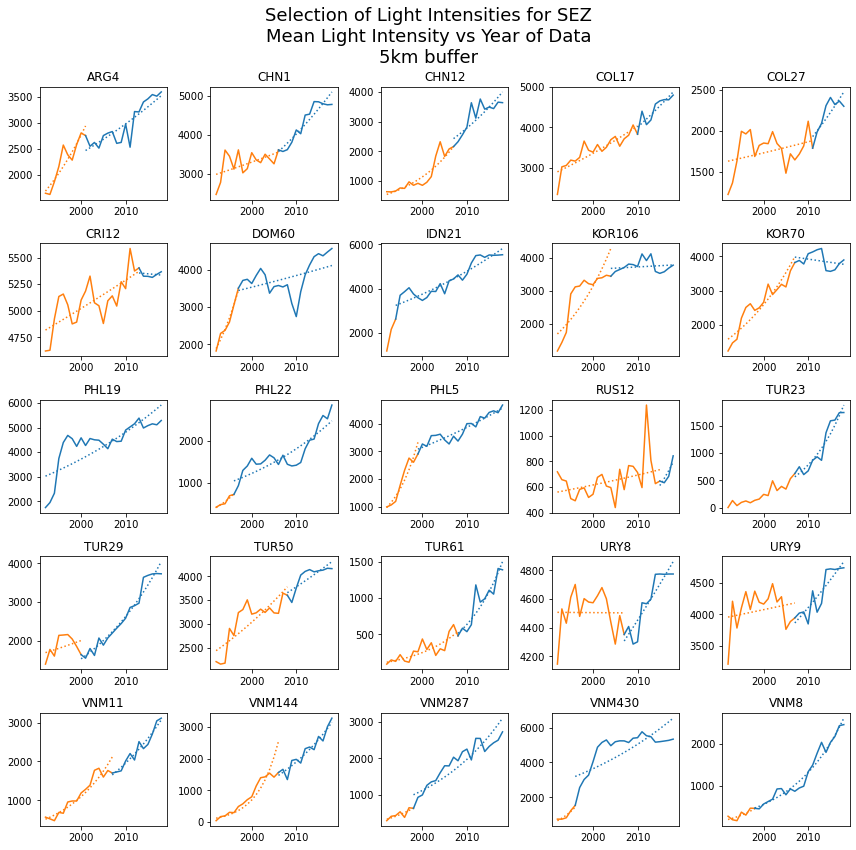

In [3]:
from random import choice

def fit_line(x, y=None):
    """Create the fitted y values for an exponential curve fit. """
    
    r, x0 = exp_line_fit(x, y)
    y_ = x0*(r+1)**x
    return y_
    

def plot_sez_ts(df, title=''):
    """Plot SEZ time series values, with fitted values """
    
    g = df.groupby('unique_id')

    
    all_keys = list(g.groups.keys()) # Random selection
    shuffle(all_keys)
    
    # Pick a square that is less than the total number of keys, 
    # and also less than 25
    size = int(min(np.floor(np.sqrt(len(all_keys))), 5))
    
    fig, axes = plt.subplots(size,size, figsize=(12,12))
    
    # Preselect the keys so we can sort them for display
    rand_series = []
    ki = iter(all_keys)

    for _ in range(size**2):
        while True: # Skip the ones that are empty
            try:
                uid = next(ki)
                bf, af = split_series(g.get_group(uid))
                if len(bf) > 0 and len(af) > 0:
                    rand_series.append([uid, bf, af])
                    break
            except StopIteration:
                break # Number of non empty is less than size
        

    for ax, (uid, bf, af) in zip(np.ravel(axes),sorted(rand_series, key=lambda e: e[0])) : 

        a1 = ax.plot(bf.year, bf.mean_light, color='tab:orange')
        y_ = fit_line(bf.year, bf.mean_light)
        ax.plot(bf.year, y_, color='tab:orange', linestyle=':')

        ax.plot(af.year, af.mean_light, color='tab:blue')
        y_ = fit_line(af.year, af.mean_light)
        ax.plot(af.year, y_, color='tab:blue', linestyle=':')

        ax.set_title(uid)

    fig.suptitle(f"Selection of Light Intensities for SEZ\nMean Light Intensity vs Year of Data\n{title}", fontsize=18)
    plt.tight_layout()
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_sez_ts(df5.rename(columns={'buffer_pix_sum':'mean_light'}), title='5km buffer')


The plot above is a random selection of 25 SEZ, showing the light intensity over time ( solid line ). Where the line is orange is the time before the SEZ become active, and the blue ortion is after. The dotted lines are a line fit to the log of the light intensity, so the slope of the fit is the growth rate of the light intensity, assuming a model of exponential growth. ( Which is why some of the dotted lines are curved. ) 

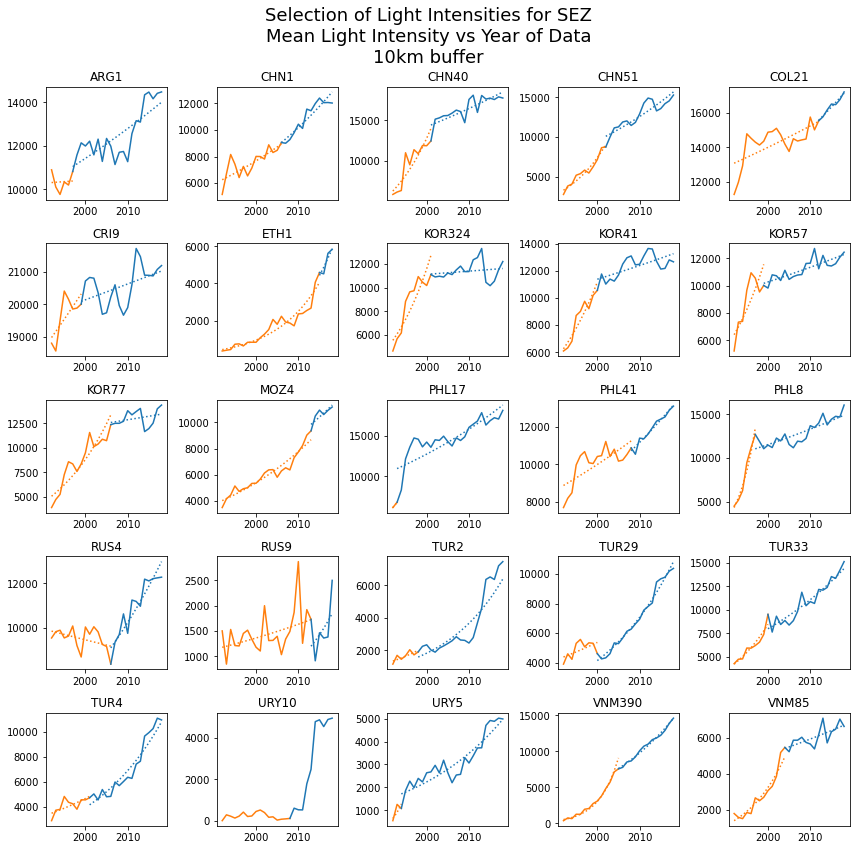

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_sez_ts(df10.rename(columns={'buffer_pix_sum':'mean_light'}), title='10km buffer')


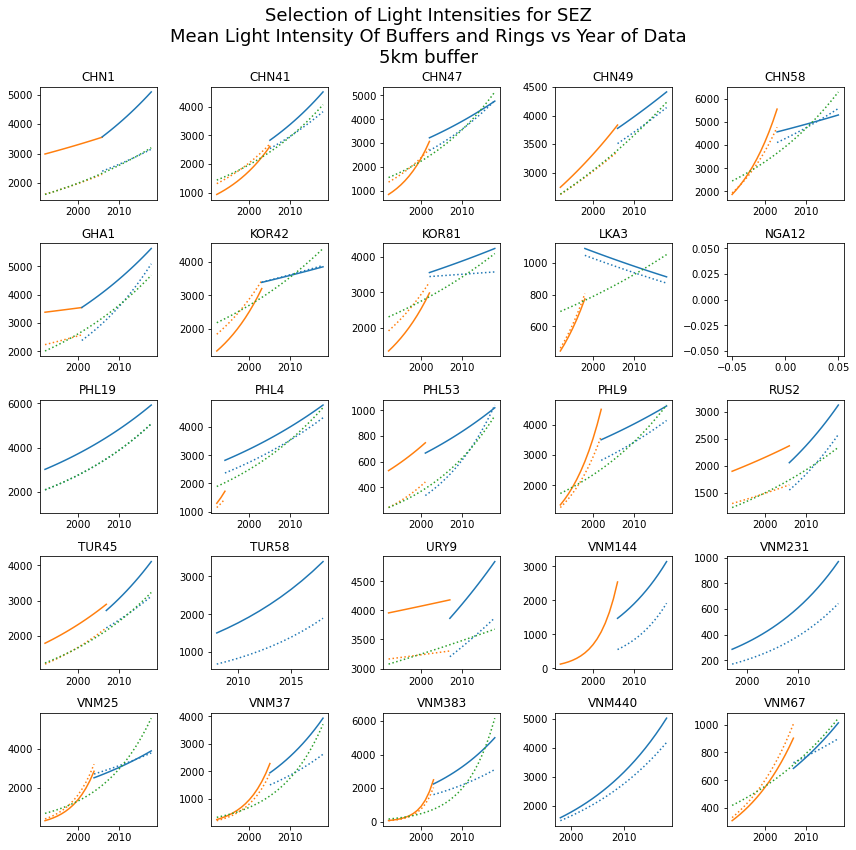

In [5]:
def plot_sez_rings_ts(df, title='', max_size=5):
    
    g = df.groupby('unique_id')

    
    all_keys = list(g.groups.keys()) # Random selection
    shuffle(all_keys)
    
    # Pick a square that is less than the total number of keys, 
    # and also less than 25
    size = int(min(np.floor(np.sqrt(len(all_keys))), max_size))
    
    fig, axes = plt.subplots(size,size, figsize=(12,12))
    
    # Preselect the keys so we can sort them for display
    rand_series = []
    ki = iter(all_keys)

    for _ in range(size**2):
        while True: # Skip the ones that are empty
            try:
                uid = next(ki)
                gf = g.get_group(uid)
                bf, af = split_series(gf, col='buffer_pix_sum')
                if len(bf) > 0 and len(af) > 0:
                    rand_series.append([uid, gf,bf, af])
                    break
            except StopIteration:
                break # Number of non empty is less than size
        

    for ax, (uid, gf,bf, af) in zip(np.ravel(axes),sorted(rand_series, key=lambda e: e[0])) : 

        
        y_ = fit_line(bf.year, bf.buffer_pix_sum)
        ax.plot(bf.year, y_, color='tab:orange')
        
        y_ = fit_line(bf.year, bf.ring_pix_sum)
        ax.plot(bf.year, y_, color='tab:orange', linestyle=':')

        y_ = fit_line(af.year, af.buffer_pix_sum)
        ax.plot(af.year, y_, color='tab:blue')
        
        y_ = fit_line(af.year, af.ring_pix_sum)
        ax.plot(af.year, y_, color='tab:blue', linestyle=':')
        
        y_ = fit_line(gf.year, gf.ring_pix_sum)
        ax.plot(gf.year, y_, color='tab:green', linestyle=':')

        ax.set_title(uid)

    fig.suptitle(f"Selection of Light Intensities for SEZ\nMean Light Intensity Of Buffers and Rings vs Year of Data\n{title}", fontsize=18)
    plt.tight_layout()
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_sez_rings_ts(df5, title='5km buffer')

In the plot above, the solid lines are exponential curve fits to the annual light intensity for the buffer, a circular region around each SEZ extending to 5km. The dotted lines are for the ring,  which starts at 5km from the SEZ and extends to 7.07km. ( The ring size is chosen so it has an area equal to that of the buffer. ) 

The orange lines are for the time period before the SEZ became operational, and the blue is after. 

The gree line is the exponential curve fit for the light intensity of the ring, for the whole dataset. So the green line is the assumption that the establishment of the SEZ should have no impact on the ring area. 

Light intensity is computed as the sum of all pixel values in the area for a year from the harmonized Nighttime Lights raster set. 



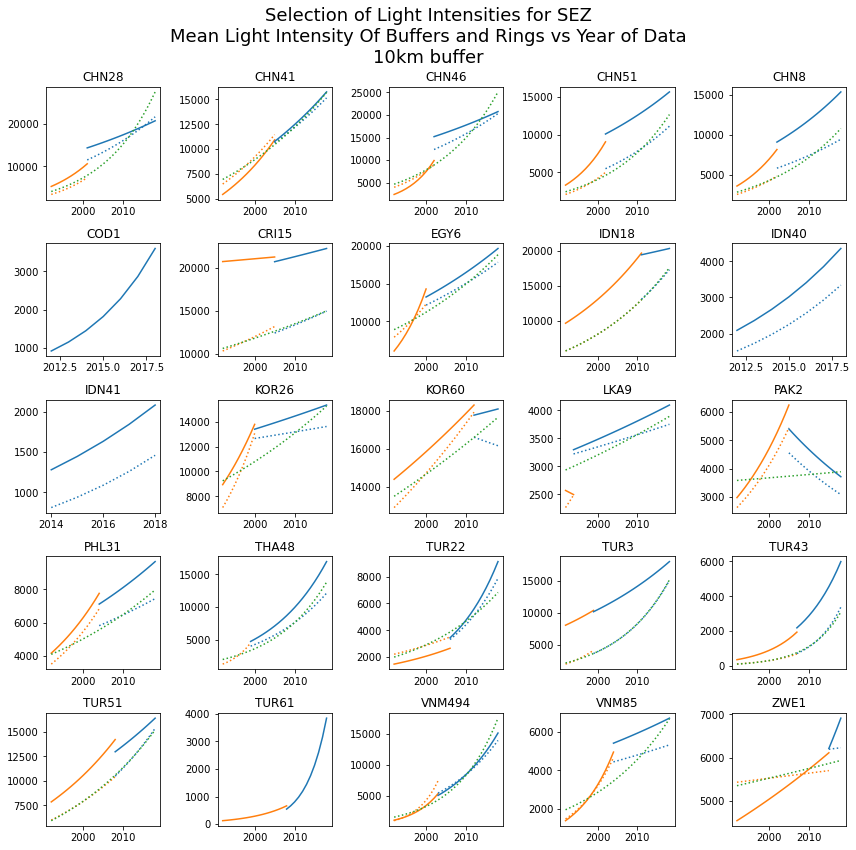

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_sez_rings_ts(df10, title='10km buffer')

In [7]:
rows = []



with warnings.catch_warnings():
    warnings.simplefilter("ignore")  

    for (unique_id, radius), gf in df10.groupby(['unique_id', 'radius']):
        bf, af = split_series(gf, col='buffer_pix_sum')

        row = [
            unique_id,
            radius,
            *exp_line_fit(bf.year, bf.buffer_pix_sum),
            *exp_line_fit(bf.year, bf.ring_pix_sum),
            *exp_line_fit(af.year, af.buffer_pix_sum),
            *exp_line_fit(af.year, af.ring_pix_sum),
            *exp_line_fit(gf.year, gf.ring_pix_sum)
        ]

        rows.append(row)

  
fits = pd.DataFrame(rows, 
    columns="unique_id radius pre_buf_r pre_buf_x0 pre_ring_r pre_ring_x0 "
             "post_buf_r post_buf_x0 post_ring_r post_ring_x0 "
             "total_ring_r total_ring_x0".split() )
    
dff = dfml.merge(fits)
    
fits.head()

,unique_id,radius,pre_buf_r,pre_buf_x0,pre_ring_r,pre_ring_x0,post_buf_r,post_buf_x0,post_ring_r,post_ring_x0,total_ring_r,total_ring_x0
0,AGO1,10000,0.131032,4.685385e-104,0.118595,1.291571e-94,0.015247,1.146066e-09,0.037349,1.327707e-28,0.120008,1.045673e-95
1,ARG1,10000,0.001377,6.654708e+02,0.014834,1.281193e-09,0.011401,1.626939e-06,0.015338,4.806208e-10,0.015838,1.785500e-10
2,ARG2,10000,0.129722,2.485502e-103,NaN,NaN,0.073665,2.960984e-59,NaN,NaN,NaN,NaN
3,ARG3,10000,0.046342,3.843448e-36,0.021097,6.995217e-15,0.021681,2.048514e-15,0.015546,3.691175e-10,0.015563,3.568191e-10
4,ARG4,10000,0.056387,1.708218e-44,0.041572,1.575463e-32,0.025571,7.497526e-19,0.026365,7.620068e-20,0.019228,9.570620e-14


In [8]:
def minimal_corr(df, min_periods=5):
    '''Produce a set of correlations of columns in a dataset tha excludes duplicates
    and correlations with self'''
    tcr = df.corr(min_periods=min_periods)          # Create a correlation matrix

    tcr = tcr.fillna(-10) # Need to keep the nans for the stack operation
    
    # Create an upper triangle matrix, so we can select only part
    # of the correlation matrix
    keep = (np.triu(np.ones(tcr.shape))   # Make a triangular matrix of 1 and 0
            .astype('bool')               # Convert it to bool
            .reshape(tcr.size))           # Turn it from a matrix to a 1D series

    tc = (tcr.stack()                     # Convert from a matris to a 1D series, with rows and col labels as row indexes
            [keep]                        # Select just the rows selected by the trianular matrix
            .to_frame('result'))          # Convert the series into a dataframe

    t = tc[tc.result<1].sort_values('result',ascending=False).reset_index()

    t =  t[ (np.abs(t.result) > .1) & ( t.result != -10 )]
    
    t.columns  = ['col1','col2', 'crr']

    
    return t

x0_cols = [e for e in df5.columns if 'x0' in e]


In [9]:
rows= []
for (country, radius), gf in dff.groupby(['country','radius']):
    rows.append(
       (country, radius, len(gf), gf.pre_buf_r.corr(gf.pre_ring_r), gf.post_buf_r.corr(gf.post_ring_r))
    )
    
t = pd.DataFrame(rows, columns='country radius n pre post'.split()).dropna()
t.sort_values('pre',ascending=False)

,country,radius,n,pre,post
34,Malaysia,10000,108,1.000000,0.693224
32,Lesotho,10000,54,1.000000,1.000000
43,South Africa,10000,54,1.000000,-1.000000
27,Indonesia,10000,729,0.992507,0.903053
46,Tanzania,10000,162,0.989194,0.975314
37,Pakistan,10000,108,0.963881,0.990882
18,Ethiopia,10000,243,0.955480,0.941612
26,India,10000,243,0.937904,0.744518
44,Sri Lanka,10000,351,0.936539,0.518468
38,Philippines,10000,1269,0.909413,0.788776


In [10]:
t = fits[fits.radius==10000].set_index(['unique_id','radius']).drop(columns=['total_ring_r']+x0_cols)
minimal_corr(t)

,col1,col2,crr
0,post_buf_x0,post_ring_x0,0.815825
1,post_buf_r,post_ring_r,0.731212
2,pre_buf_r,pre_ring_r,0.449506
3,pre_buf_r,post_buf_r,0.137115
